In [1]:
import h5py
import numpy as np

In [2]:
pion = h5py.File("../dataset/ChPiEscan_1_1_DownSampled.h5", "r")
pion_ECAL = np.array(pion.get("ECAL"))
pion_HCAL = np.array(pion.get("HCAL"))
ele = h5py.File("../dataset/EleEscan_1_1_DownSampled.h5", "r")
ele_ECAL = np.array(ele.get("ECAL"))
ele_HCAL = np.array(ele.get("HCAL"))

In [3]:
y_pion = np.zeros(pion_ECAL.shape[0])
y_ele  = np.ones(ele_ECAL.shape[0])
y = np.concatenate([y_pion,y_ele])
#
x_ECAL = np.concatenate([pion_ECAL, ele_ECAL],axis=0)
x_ECAL = np.reshape(x_ECAL, (x_ECAL.shape[0], x_ECAL.shape[1], x_ECAL.shape[2],1))
x_HCAL = np.concatenate([pion_HCAL, ele_HCAL],axis=0)
x_HCAL = np.reshape(x_HCAL, (x_HCAL.shape[0], x_HCAL.shape[1], x_HCAL.shape[2],1))
#Normalize energy between 0 and 1
x_ECAL = x_ECAL/np.max(x_ECAL)
x_HCAL = x_HCAL/np.max(x_HCAL)
#
x = np.concatenate([x_ECAL, x_HCAL], axis=-1)
print(x.shape, y.shape)

(20000, 7, 7, 2) (20000,)


In [4]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(x, y, test_size=0.33)
print(X_train.shape, X_val.shape, y_train.shape, y_val.shape)

(13400, 7, 7, 2) (6600, 7, 7, 2) (13400,) (6600,)


In [5]:
# keras imports
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Conv2D, Dropout, Flatten
from tensorflow.keras.layers import MaxPooling2D, AveragePooling2D, BatchNormalization, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN

In [6]:
img_rows = X_train.shape[1]
img_cols = X_train.shape[2]
dropoutRate = 0.25

In [7]:
image_shape = (7, 7, 2)
####
inputImage = Input(shape=(image_shape))
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(inputImage)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = AveragePooling2D( pool_size = (3,3), strides=(2, 2))(x)
#x = Dropout(dropoutRate)(x)
#
x = Conv2D(3, kernel_size=(3,3), data_format="channels_last", strides=(1, 1), padding="same")(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = MaxPooling2D( pool_size = (2,2), strides=(1, 1))(x)
#x = Dropout(dropoutRate)(x)
#
x = Flatten()(x)
#
x = Dense(6, activation='relu')(x)
#
output = Dense(1, activation='sigmoid')(x)
####
model = Model(inputs=inputImage, outputs=output)

2022-04-11 15:21:05.898238: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-11 15:21:05.900839: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 7, 2)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 3)           57        
_________________________________________________________________
batch_normalization (BatchNo (None, 7, 7, 3)           12        
_________________________________________________________________
activation (Activation)      (None, 7, 7, 3)           0         
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 3)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 3)           84        
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 3)           12    

In [9]:
model.save('model.h5')

In [114]:
batch_size = 128
n_epochs = 100
# train 
history = model.fit(X_train, y_train, epochs=n_epochs, batch_size=batch_size, verbose = 2,
                validation_data=(X_val, y_val),
                callbacks = [
                EarlyStopping(monitor='val_loss', patience=10, verbose=1),
                ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=1),
                TerminateOnNaN()])

Epoch 1/100
105/105 - 2s - loss: 0.5030 - val_loss: 0.6640
Epoch 2/100
105/105 - 1s - loss: 0.2102 - val_loss: 0.5696
Epoch 3/100
105/105 - 1s - loss: 0.1217 - val_loss: 0.4104
Epoch 4/100
105/105 - 1s - loss: 0.0892 - val_loss: 0.2988
Epoch 5/100
105/105 - 1s - loss: 0.0731 - val_loss: 0.2331
Epoch 6/100
105/105 - 1s - loss: 0.0627 - val_loss: 0.1846
Epoch 7/100
105/105 - 1s - loss: 0.0553 - val_loss: 0.1939
Epoch 8/100
105/105 - 1s - loss: 0.0491 - val_loss: 0.1250
Epoch 9/100
105/105 - 1s - loss: 0.0461 - val_loss: 0.2950
Epoch 10/100
105/105 - 1s - loss: 0.0429 - val_loss: 0.1335

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 11/100
105/105 - 1s - loss: 0.0410 - val_loss: 0.0600
Epoch 12/100
105/105 - 1s - loss: 0.0393 - val_loss: 0.0533
Epoch 13/100
105/105 - 1s - loss: 0.0397 - val_loss: 0.0432
Epoch 14/100
105/105 - 1s - loss: 0.0390 - val_loss: 0.0417
Epoch 15/100
105/105 - 1s - loss: 0.0388 - val_loss: 0.0544
Epoch 16/100
105/105 - 1s -

In [115]:
import matplotlib.pyplot as plt
%matplotlib inline

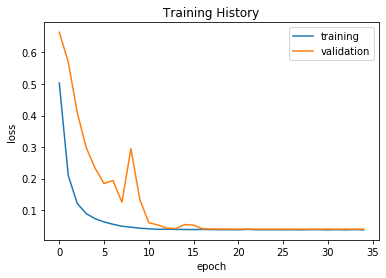

In [116]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

/Users/maurizio/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


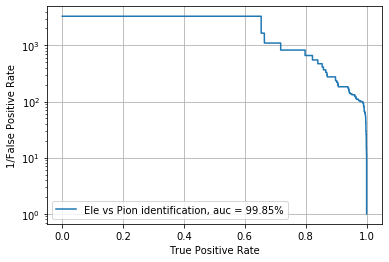

In [117]:
from sklearn.metrics import roc_curve, auc
predict_val = model.predict(X_val)
plt.figure()
fpr, tpr, threshold = roc_curve(y_val, predict_val)
my_auc = auc(fpr, tpr)
plt.plot(tpr,1./fpr,label='Ele vs Pion identification, auc = %.2f%%'%(my_auc*100.))
plt.semilogy()
plt.xlabel("True Positive Rate")
plt.ylabel("1/False Positive Rate")
#plt.ylim(0.001,1)
plt.grid(True)
plt.legend(loc='lower left')
plt.show()